In [1]:
import datetime
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from art.attacks.evasion import BasicIterativeMethod, FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from region_based_classifier import RegionBasedClassifier
from util import dataset2tensor, get_correct_examples

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

n_threads = os.cpu_count()
print('CPU threads: {}'.format(n_threads))

Device: cuda
CPU threads: 24


In [4]:
PATH_DATA = 'data'
PATH_RESULTS = os.path.join('results', 'mnist_base_model.pt')
BATCH_SIZE = 128
EPOCHS = 20
N_ADV = 2000

In [5]:
# Fetch dataset
transforms = tv.transforms.Compose([tv.transforms.ToTensor()])
dataset_train = datasets.MNIST(PATH_DATA, train=True, download=True, transform=transforms)
dataset_test = datasets.MNIST(PATH_DATA, train=False, download=True, transform=transforms)

# From PyTorch dataset to Numpy array
tensor_X_train, tensor_y_train = dataset2tensor(dataset_train)
X_train = tensor_X_train.cpu().detach().numpy()
y_train = tensor_y_train.cpu().detach().numpy()
tensor_X_test, tensor_y_test = dataset2tensor(dataset_test)
X_test = tensor_X_test.cpu().detach().numpy()
y_test = tensor_y_test.cpu().detach().numpy()

# Split model training set into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=5000)
dataset_train = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.int64))

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# Check sizes
print(X_train.shape, X_val.shape, X_test.shape)

(55000, 1, 28, 28) (5000, 1, 28, 28) (10000, 1, 28, 28)


## Train point-based classifier

In [7]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(1)
        self.fc1 = nn.Linear(9216, 200)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(200, 10)
        self.softmax = nn.Softmax(dim=1)

    def before_softmax(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.before_softmax(x)
        x = self.softmax(x)
        return x

In [8]:
# Create Neural Network model
model = BaseModel()
model.to(device)
print('Number of layers: {}'.format(len(list(model.children()))))

Number of layers: 10


In [9]:
def train(model, loader, loss, optimizer):
    model.train()
    total_loss = 0.
    corrects = 0.
    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)
        
        optimizer.zero_grad()
        outputs = model(x)
        l = loss(outputs, y)
        l.backward()
        optimizer.step()

        # for display
        total_loss += l.item() * batch_size
        preds = outputs.max(1, keepdim=True)[1]
        corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [10]:
def validate(model, loader, loss, device=device):
    model.eval()
    total_loss = 0.
    corrects = 0.
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            outputs = model(x)
            l = loss(outputs, y)
            total_loss += l.item() * batch_size
            preds = outputs.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [11]:
def predict(model, X, batch_size=BATCH_SIZE, device=device):
    model.eval()
    dataset = TensorDataset(X)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    tensor_pred = -torch.ones(len(X), dtype=torch.int64)
    
    start = 0
    with torch.no_grad():
        for x in loader:
            x = x[0].to(device)
            n = x.size(0)
            end = start + n
            outputs = model(x)
            tensor_pred[start:end] = outputs.max(1)[1].type(torch.int64)
            start += n

    return tensor_pred

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss=nn.CrossEntropyLoss()

In [13]:
# DO NOT RUN THIS IF YOU DON'T NEED RETRAIN!
# since = time.time()
# for epoch in range(EPOCHS):
#     start = time.time()
#     tr_loss, tr_acc = train(model, dataloader_train, loss, optimizer)
#     va_loss, va_acc = validate(model, dataloader_test, loss)
    
#     time_elapsed = time.time() - start
#     print(('{:2d}/{:d}[{:s}] Train Loss: {:.4f} Acc: {:.4f}%, ' +
#         'Test Loss: {:.4f} Acc: {:.4f}%').format(
#             epoch+1, EPOCHS, str(datetime.timedelta(seconds=time_elapsed)),
#             tr_loss, tr_acc*100.,
#             va_loss, va_acc*100.))
    
# time_elapsed = time.time() - since
# print('Total run time: {:.0f}m {:.1f}s'.format(
#     time_elapsed // 60,
#     time_elapsed % 60))

# if not os.path.exists('results'):
#     os.makedirs('results')

# torch.save(model.state_dict(), PATH_RESULTS)

In [14]:
# Load model from saved file
model.load_state_dict(torch.load(PATH_RESULTS))

_, acc_test = validate(model, dataloader_test, loss)
print('Test set accuracy: {:.4f}'.format(acc_test*100))

Test set accuracy: 97.5800


## Remove missclassified samples

In [15]:
print('Training set: {}'.format(len(dataset_train)))
tensor_train_X, tensor_train_y = get_correct_examples(model, dataset_train, device=device, return_tensor=True)
dataset_train_perfect = TensorDataset(tensor_train_X, tensor_train_y)
dataloader_train_perfect = DataLoader(dataset_train_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_train_perfect, loss)
print('Accuracy on {} filtered training examples: {:.4f}%'.format(len(dataloader_train_perfect.dataset), acc*100))

print('Test set: {}'.format(len(dataset_test)))
tensor_test_X, tensor_test_y = get_correct_examples(model, dataset_test, device=device, return_tensor=True)
dataset_test_perfect = TensorDataset(tensor_test_X, tensor_test_y)
dataloader_test_perfect = DataLoader(dataset_test_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_test_perfect, loss)
print('Accuracy on {} filtered test examples: {:.4f}%'.format(len(dataloader_test_perfect.dataset), acc*100))

Training set: 55000
Accuracy on 53998 filtered training examples: 100.0000%
Test set: 10000
Accuracy on 9758 filtered test examples: 100.0000%


## Create adversarial examples 

In [31]:
classifier = PyTorchClassifier(
    model=model, 
    loss=loss, 
    input_shape=(1, 28, 28), 
    optimizer=optimizer,
    nb_classes=10,
    clip_values=(0.0, 1.0),
    device_type=device
)

# attack = FastGradientMethod(estimator=classifier, eps=0.2)
attack = BasicIterativeMethod(estimator=classifier, eps=0.2)

In [32]:
# Prepare dataset for adversarial examples
n = len(dataset_test_perfect)
indices = torch.randperm(n)[:N_ADV]

pt_subset_X = tensor_test_X[indices]  # PyTorch Tensor
pt_subset_y = tensor_test_y[indices]

subset_X = pt_subset_X.cpu().detach().numpy()
subset_y = pt_subset_y.cpu().detach().numpy()

In [33]:
# Create adversarial examples
subset_pred = np.argmax(classifier.predict(subset_X), axis=1)
accuracy = np.sum(subset_pred == subset_y) / float(len(subset_pred))
print("Model accuracy on clean examples: {:.4f}%".format(accuracy * 100))

# Generate adversarial examples
subset_adv = attack.generate(x=subset_X)
subset_pred = np.argmax(classifier.predict(subset_adv), axis=1)

accuracy = np.sum(subset_pred == subset_y) / float(len(subset_pred))
print("Model accuracy on adversarial examples: {:.4f}%".format(accuracy * 100))

PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]Model accuracy on clean examples: 100.0000%
Model accuracy on adversarial examples: 6.9000%


## Feature Squeezing

In [34]:
from feature_squeezing import GaussianSqueezer, MedianSqueezer, DepthSqueezer, FeatureSqueezingTorch

In [35]:
squeezers = []
squeezers.append(GaussianSqueezer(x_min=0.0, x_max=1.0, noise_strength=0.025, std=1.0))
squeezers.append(MedianSqueezer(x_min=0.0, x_max=1.0, kernel_size=3))
squeezers.append(DepthSqueezer(x_min=0.0, x_max=1.0, bit_depth=8))
# std = 4.1936 / 20.0
# print('std=', std)
# squeezers.append(GaussianSqueezer(x_min=0.0, x_max=1.0, noise_strength=1, std=std))

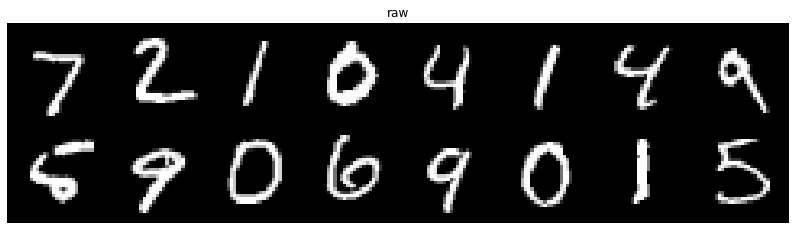

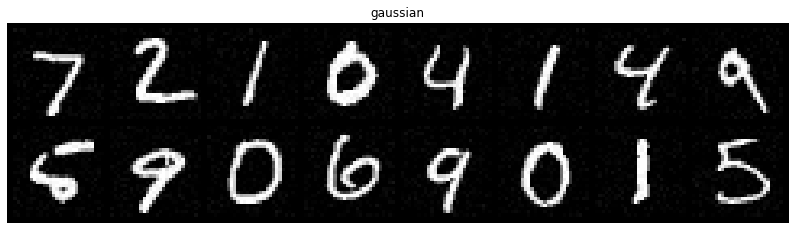

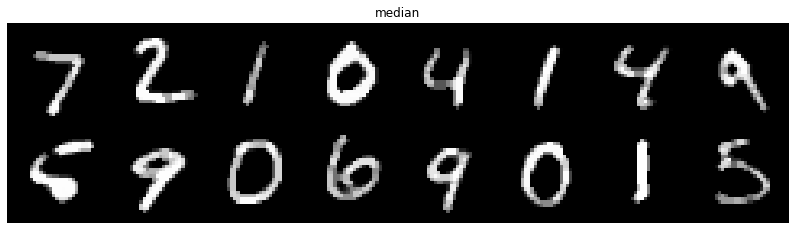

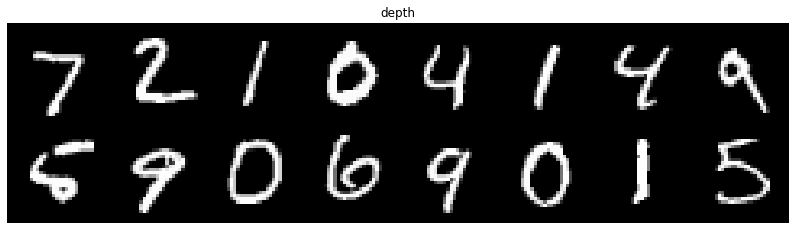

In [36]:
# Show squerzers' outputs
X_transformed = torch.from_numpy(X_test[:16])
grid_image = make_grid(X_transformed).permute(1, 2, 0).detach().numpy()
plt.figure(figsize=(14, 4))
plt.imshow(grid_image)
plt.axis('off')
plt.title('raw')
plt.show()

for s in squeezers:
    X_transformed = s.transform(X_test[:16])
    X_transformed = torch.from_numpy(X_transformed)
    grid_image = make_grid(X_transformed).permute(1, 2, 0).detach().numpy()
    plt.figure(figsize=(14, 4))
    plt.imshow(grid_image)
    plt.axis('off')
    plt.title(s.name)
    plt.show()

In [37]:
fs = FeatureSqueezingTorch(
    classifier=model,
    lr=0.001,
    momentum=0.9,
    loss=loss,
    batch_size=128,
    x_min=0.0,
    x_max=1.0,
    squeezers=squeezers,
    n_class=10,
    device=device)

In [38]:
fs.fit(X_train, y_train, epochs=EPOCHS, verbose=1)

 1/20 [0:00:01.694120] Squeezer: gaussian Train loss: 1.4778 acc: 98.3964%
 2/20 [0:00:01.799594] Squeezer: gaussian Train loss: 1.4763 acc: 98.5527%
 3/20 [0:00:01.741234] Squeezer: gaussian Train loss: 1.4754 acc: 98.6564%
 4/20 [0:00:01.755989] Squeezer: gaussian Train loss: 1.4751 acc: 98.6909%
 5/20 [0:00:01.776661] Squeezer: gaussian Train loss: 1.4747 acc: 98.7345%
 6/20 [0:00:01.765001] Squeezer: gaussian Train loss: 1.4744 acc: 98.7745%
 7/20 [0:00:01.761118] Squeezer: gaussian Train loss: 1.4743 acc: 98.7891%
 8/20 [0:00:01.778808] Squeezer: gaussian Train loss: 1.4740 acc: 98.8218%
 9/20 [0:00:01.708134] Squeezer: gaussian Train loss: 1.4738 acc: 98.8491%
10/20 [0:00:01.660170] Squeezer: gaussian Train loss: 1.4736 acc: 98.8473%
11/20 [0:00:01.660028] Squeezer: gaussian Train loss: 1.4734 acc: 98.8673%
12/20 [0:00:01.655151] Squeezer: gaussian Train loss: 1.4733 acc: 98.9000%
13/20 [0:00:01.656779] Squeezer: gaussian Train loss: 1.4731 acc: 98.9145%
14/20 [0:00:01.638711] Sq

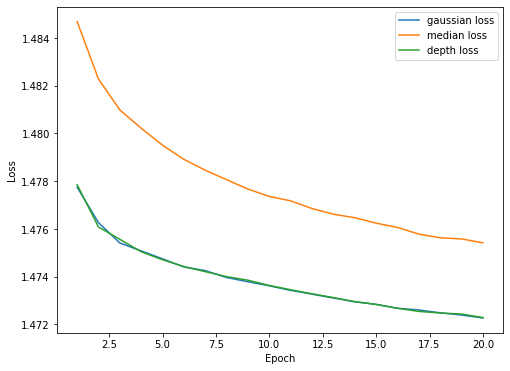

In [39]:
history_losses = fs.history_losses
n = len(history_losses[0])

plt.figure(figsize=(8, 6))
xx = np.arange(1, n+1)
for i in range(len(squeezers)):
    name = squeezers[i].name
    plt.plot(xx, history_losses[i], label='{} loss'.format(name))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Search threshold

In [40]:
X_mixed = np.concatenate((subset_adv[1000:], subset_X[1000:]))
y_adv = np.concatenate((np.ones_like(subset_y[1000:]), np.zeros_like(subset_y[1000:])))
fs.search_threshold(X_mixed, y_adv)

## Testing FS on clean data

In [41]:
predictions = fs.predict(subset_X[:1000])
fp = np.sum(predictions==1) / float(len(subset_X[:1000]))
print('False postive rate: {:.4f}%'.format(fp*100))

False postive rate: 23.0000%


## Testing FS on Adversarial Examples

In [42]:
predictions = fs.predict(subset_adv[:1000])
tp = np.sum(predictions==1) / float(len(subset_X[:1000]))
print('True postive rate: {:.4f}%'.format(tp*100))

True postive rate: 79.2000%


## ROC AUC

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from util import get_roc

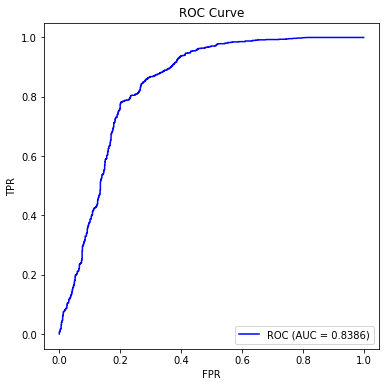

Detector ROC-AUC score: 0.8386, accuracy: 0.7815, precision: 0.7730, recall: 0.7970


In [44]:
X_mixed_test = np.concatenate((subset_adv[:1000], subset_X[:1000]))
y_adv_test = np.concatenate((np.ones_like(subset_y[1000:]), np.zeros_like(subset_y[1000:])))

fs_label_pred = fs.predict(X_mixed_test)
fs_label_prob = fs.predict_proba(X_mixed_test)[:, 1]
_, _, auc_score, _ = get_roc(y_adv_test, fs_label_prob, show_plot=True)
precision = precision_score(y_adv_test, fs_label_pred)
recall = recall_score(y_adv_test, fs_label_pred)
acc = accuracy_score(y_adv_test, fs_label_pred)

print('Detector ROC-AUC score: {:0.4f}, accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(
    auc_score, acc, precision, recall))